---
title: "强化学习专题 - 蒙特卡洛强化学习"
date: 2025-06-06T23:22:00+08:00
author: "Liu Zheng"
tags: ["笔记", "实验", "AI", "强化学习"]
categories: "实验笔记"
---

# 蒙特卡洛强化学习

蒙特卡洛方法是一种通过对环境进行多次采样，利用样本平均来估计状态或动作价值的方法。它不依赖于环境的完整模型，而是基于实际经验轨迹进行学习，适用于模型未知或难以建模的情形。

> **注意**：蒙特卡洛强化学习（Monte Carlo Reinforcement Learning） 和 蒙特卡洛树搜索（Monte Carlo Tree Search, MCTS） 是不同的算法体系，尽管它们都用到了“蒙特卡洛”思想（即基于采样的方法进行估计），但目的、适用场景和方法结构都有显著区别：
> 
> | 维度 | 蒙特卡洛强化学习 | 蒙特卡洛树搜索（MCTS） |
> | --- | --- | --- |
> | 应用领域 | 强化学习（RL），估计策略价值或学习最优策略 | 搜索问题，特别是博弈（如围棋、象棋） |
> | 目标 | 学习最优策略或状态-动作值函数（Q值） | 在给定状态下选择最优动作 |
> | 主要思想 | 通过多次完整的 episode 采样来估计期望回报 | 通过模拟和树状搜索估计每个动作的潜在价值 |
> | 是否建树 | 否 | 是（构建一个状态-动作搜索树） |
> | 是否使用值函数 | 是，学习 $V(s)$ 或 $Q(s, a)$ | 通常不直接学习函数值，而是统计平均回报 |


## 1. 数学原理

> **算法实现**
> 
> $
> \begin{array}{l}
> input:\  \text{MDP}\ = \{ S, A, s_0, P_a(s' \mid s), R(s,a,s')\}\\
> output:\ \text{Q-function}\ Q\\[4mm]
> \text{Initialise}\ Q\ \text{arbitrarily;}\\
> Q(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a, N(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a\\[4mm]
> repeat \\
> \quad\quad \text{Generate an episode}\ (s_0, a_0, r_1, \ldots, s_{T-1}, a_{T-1}, r_T);\\
> \quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad G \leftarrow 0, t \leftarrow T-1\\
> \quad\quad while\ t \geq 0\ do\\
> \quad\quad\quad\quad G \leftarrow R_{t+1} + \gamma \cdot G\\
> \quad\quad\quad\quad if\ s_t, a_t\ \text{does not appear in}\ s_0, a_0,\ldots, s_{t-1}, a_{t-1}\ then\\
> \quad\quad\quad\quad\quad\quad Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \frac{1}{N(s_t, a_t)}[G - Q(s_t, a_t)], N(s_t, a_t) \leftarrow N(s_t, a_t) + 1\\
> \quad\quad\quad\quad t \leftarrow t-1\\
> until\ Q\ \text{converges}
> \end{array}
> $

## 2. 案例场景

我们同样选择 Frozen Lake 场景作为训练场景。

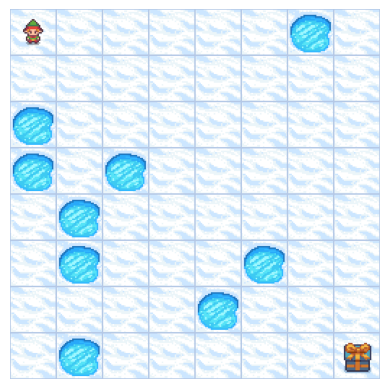

In [1]:
import gymnasium
import matplotlib.pyplot
import numpy
from collections import defaultdict
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

SIZE = 8

ENV = gymnasium.make("FrozenLake-v1", desc=generate_random_map(SIZE), map_name=f"{SIZE}x{SIZE}", is_slippery=False, render_mode="rgb_array")
ENV.reset()

image = ENV.render()

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()

In [2]:
class MCMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))
        self.Nt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose_action(self, s, eps):
        if numpy.random.rand() < eps:
            return self.env.action_space.sample()
        return numpy.argmax(self.Qt[s])

    def generate_episode(self, eps):
        T = []
        s, _ = self.env.reset()
        done = False
        while not done:
            a = self.choose_action(s, eps)
            sn, Rsa, done, _, _ = self.env.step(a)
            T.append((s, a, Rsa))
            s = sn
        return T

    def build(self, gamma=0.99, num_episodes=1000, theta=1e-6, eps=0.1):
        for n in range(num_episodes):
            T = self.generate_episode(eps)
            G = 0
            delta = 0
            visited = set()
            for st, at, Rsa in reversed(T):
                G = Rsa + gamma * G
                if (st, at) not in visited:
                    visited.add((st, at))
                    self.Nt[st][at] += 1
                    Q = self.Qt[st][at]
                    self.Qt[st][at] += (1 / self.Nt[st][at]) * (G - Q)
                    delta = max(delta, abs(self.Qt[st][at] - Q))
            if delta < theta:
                break

    def decision(self):
        policy = {}
        for s in self.S:
            policy[s] = int(numpy.argmax(self.Qt[s]))
        return policy

In [3]:
class QLMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose_action(self, s, eps):
        if numpy.random.rand() < eps:
            return self.env.action_space.sample()
        return numpy.argmax(self.Qt[s])

    def build(self, alpha=0.1, gamma=0.99, num_episodes=1000, theta=1e-6, eps=1.0):
        for n in range(num_episodes):
            G = 0
            s, _ = self.env.reset()
            done = False
            step = 0
            while not done:
                a = self.choose_action(s, eps)
                sn, Rsa, done, _, _ = self.env.step(a)
                snm = numpy.max(self.Qt[sn])
                tdt = Rsa + gamma * snm
                tde = tdt - self.Qt[s][a]
                self.Qt[s][a] += alpha * tde
                s = sn
                G += Rsa
                step += 1

    def decision(self, s):
        return int(numpy.argmax(self.Qt[s])), numpy.argmax(self.Qt[s])

    def evaluate(self, figure):
        image = self.env.render()
        subplot = figure.add_subplot()
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        while True:
            a, _ = self.decision(s)
            s, _, done, truncated, _ = self.env.step(a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)
        matplotlib.pyplot.show()

    def simulation(self, num_episodes=100):
        total_rewards = []
        successful_episodes = 0
        for episode in range(num_episodes):
            s, _ = self.env.reset()
            done = False
            truncated = False
            R = 0
            while not done and not truncated:
                a, _ = self.decision(s)
                s, Rs, done, truncated, _ = self.env.step(a)
                R += Rs
                if done and Rs == 1.0:  # In FrozenLake, reward is 1.0 only upon reaching 'G'
                    successful_episodes += 1
            total_rewards.append(R)
        success_rate = successful_episodes / num_episodes * 100
        avg_reward = numpy.mean(total_rewards)
        print(f"\nRunning {num_episodes} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")
        print(f"Average Reward: {avg_reward:.4f}")

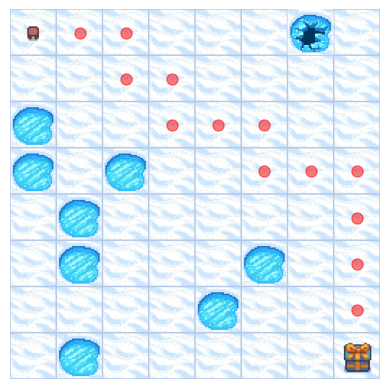


Running 100 episodes using the optimal policy:
Success Rate: 100.00%
Average Reward: 1.0000


In [4]:
INSTANCE = QLMDP(ENV)
INSTANCE.build()
INSTANCE.evaluate(matplotlib.pyplot.figure())
INSTANCE.simulation(100)